## Risk factor of cigarette smoking
#### insights from healthcare dataset analysis 

The analysis we are conducting aims to examine the risk factors caused by smoking cigarettes by analyzing a healthcare dataset. Specifically, this analysis seeks to investigate the correlation between age, blood glucose levels, smoking status, and the incidence of heart diseases. By examining these variables, we hope to identify patterns and potential risk factors associated with them.

Authors:
* Giuseppe Lentini
* Sara Di Vincenzo

In [1]:
#import section
import pandas as pd
import numpy as np
import scipy.stats as stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns

### 1 - Let's explore the dataset, first


In [2]:
# loading the dataset
path = 'healthcare-dataset-stroke-data.csv'
initial_df = pd.read_csv(path)

# we'll work on a copy of the initial DataFrame as a best practice
df = initial_df.copy()

df

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
...,...,...,...,...,...,...,...,...,...,...,...,...
5105,18234,Female,80.0,1,0,Yes,Private,Urban,83.75,NaN,never smoked,0
5106,44873,Female,81.0,0,0,Yes,Self-employed,Urban,125.20,40.0,never smoked,0
5107,19723,Female,35.0,0,0,Yes,Self-employed,Rural,82.99,30.6,never smoked,0
5108,37544,Male,51.0,0,0,Yes,Private,Rural,166.29,25.6,formerly smoked,0


In [3]:
# Exploring the values of the columns
categorical_columns = df.select_dtypes(include=['object']).columns.tolist()
numerical_columns = df.select_dtypes(exclude=['object']).columns.tolist()

print("Categorical columns: ", categorical_columns)
print("\nNumerical columns: ", numerical_columns)


print("\nUnique values in 'gender' column: ", df['gender'].unique())
print("\nUnique values in 'work_type' column: ", df['work_type'].unique())
print("\nUnique values in 'Residence_type' column: ", df['Residence_type'].unique())
print("\nUnique values in 'smoking_status' column: ", df['smoking_status'].unique())

Categorical columns:  ['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']

Numerical columns:  ['id', 'age', 'hypertension', 'heart_disease', 'avg_glucose_level', 'bmi', 'stroke']

Unique values in 'gender' column:  ['Male' 'Female' 'Other']

Unique values in 'work_type' column:  ['Private' 'Self-employed' 'Govt_job' 'children' 'Never_worked']

Unique values in 'Residence_type' column:  ['Urban' 'Rural']

Unique values in 'smoking_status' column:  ['formerly smoked' 'never smoked' 'smokes' 'Unknown']


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


In [4]:
df.describe()

,id,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000,4909.000000,5110.000000
mean,36517.829354,43.226614,0.097456,0.054012,106.147677,28.893237,0.048728
std,21161.721625,22.612647,0.296607,0.226063,45.283560,7.854067,0.215320
min,67.000000,0.080000,0.000000,0.000000,55.120000,10.300000,0.000000
25%,17741.250000,25.000000,0.000000,0.000000,77.245000,23.500000,0.000000
50%,36932.000000,45.000000,0.000000,0.000000,91.885000,28.100000,0.000000
75%,54682.000000,61.000000,0.000000,0.000000,114.090000,33.100000,0.000000
max,72940.000000,82.000000,1.000000,1.000000,271.740000,97.600000,1.000000


### 2 - Data preprocessing
Data preprocessing is a crucial step in dataset analysis. Raw data often contains errors, missing values, outliers, and inconsistencies that can distort results. Preprocessing ensures data quality and consistency by cleaning and standardizing it, making it suitable for analysis.


In [5]:
# 2.1 -fill missing bmi column with median value
df['bmi'] = df['bmi'].fillna(df['bmi'].median())
 

# 2.2 - remove unnecessary columns
cols_to_utilize = df.columns.difference(['id', 'ever_married'])
df = df[cols_to_utilize]

# 2.3 - handling outliers
def remove_outliers_IQR(keys, df):
    """
    Remove outliers from specified columns in the DataFrame using the Interquartile Range (IQR) method.

    Parameters:
    - keys (list): List of column names (keys) in the DataFrame `df` from which outliers will be removed.
    - df (DataFrame): Pandas DataFrame containing the data from which outliers will be removed.

    Returns:
    - DataFrame: A new DataFrame with outliers removed from specified columns.

    Explanation:
    Outliers are identified and removed based on the Interquartile Range (IQR) method. For each column specified 
    in `keys`, outliers are defined as values that fall below Q1 - 1.5 * IQR or above Q3 + 1.5 * IQR, where Q1 and Q3 
    are the first and third quartiles, respectively.

    Example usage:
    ```
    keys = ['bmi', 'age', 'avg_glucose_level']
    df_cleaned = remove_outliers_IQR(keys, df)
    ```
    """
    for key in keys:
        Q1 = df[key].quantile(0.25)
        Q3 = df[key].quantile(0.75)
        IQR = Q3 - Q1
        df = df[~((df[key] < (Q1 - 1.5 * IQR)) | (df[key] > (Q3 + 1.5 * IQR)))]
    return df
        
keys = ['bmi', 'age', 'avg_glucose_level']

df = remove_outliers_IQR(keys, df)

Health metrics such as BMI, glucose levels, and stroke risk factors differ significantly between children and adults. Including children in a study focused on adults could skew the results and lead to incorrect conclusions about adult health. Clear and distinct gender categories (typically male and female) enable more accurate interpretation and comparison of results. Including an "Other" category can introduce noise and ambiguity into data patterns and insights. Rows with "unknown" smoking status lack the necessary information to classify individuals into meaningful smoking categories, thus reducing the clarity and usefulness of the analysis.

In [7]:
# 2.4 - remove 'children' work_type
df = df[df['work_type'] != 'children']

# 2.5 - handle "Other" gender
df = df[df['gender'] != 'Other']

# 2.6 - handle "unknown" smoking status
df = df[df['smoking_status'] != 'Unknown']

In [5]:
# 2.7 - remove duplicate data and reset RangeIndexes
df = df.drop_duplicates()
df = df.reset_index(drop=True)
df

,Residence_type,age,avg_glucose_level,bmi,gender,heart_disease,hypertension,smoking_status,stroke,work_type
0,Rural,80.0,105.92,32.5,Male,1,0,never smoked,1,Private
1,Rural,74.0,70.09,27.4,Male,1,1,never smoked,1,Private
2,Urban,69.0,94.39,22.8,Female,0,0,never smoked,1,Private
3,Rural,81.0,80.43,29.7,Female,0,1,never smoked,1,Private
4,Rural,61.0,120.46,36.8,Female,1,0,smokes,1,Govt_job
...,...,...,...,...,...,...,...,...,...,...
2901,Rural,57.0,77.93,21.7,Female,0,0,never smoked,0,Private
2902,Urban,80.0,83.75,28.1,Female,0,1,never smoked,0,Private
2903,Urban,81.0,125.20,40.0,Female,0,0,never smoked,0,Self-employed
2904,Rural,35.0,82.99,30.6,Female,0,0,never smoked,0,Self-employed


## 3 - dataset analysis

### 3.1 - plotting the dataset

In this step, we create pie charts to visualize the distribution of categorical variables, such as gender, work type, and residence type. This helps to understand the composition of the dataset in terms of these categorical features.

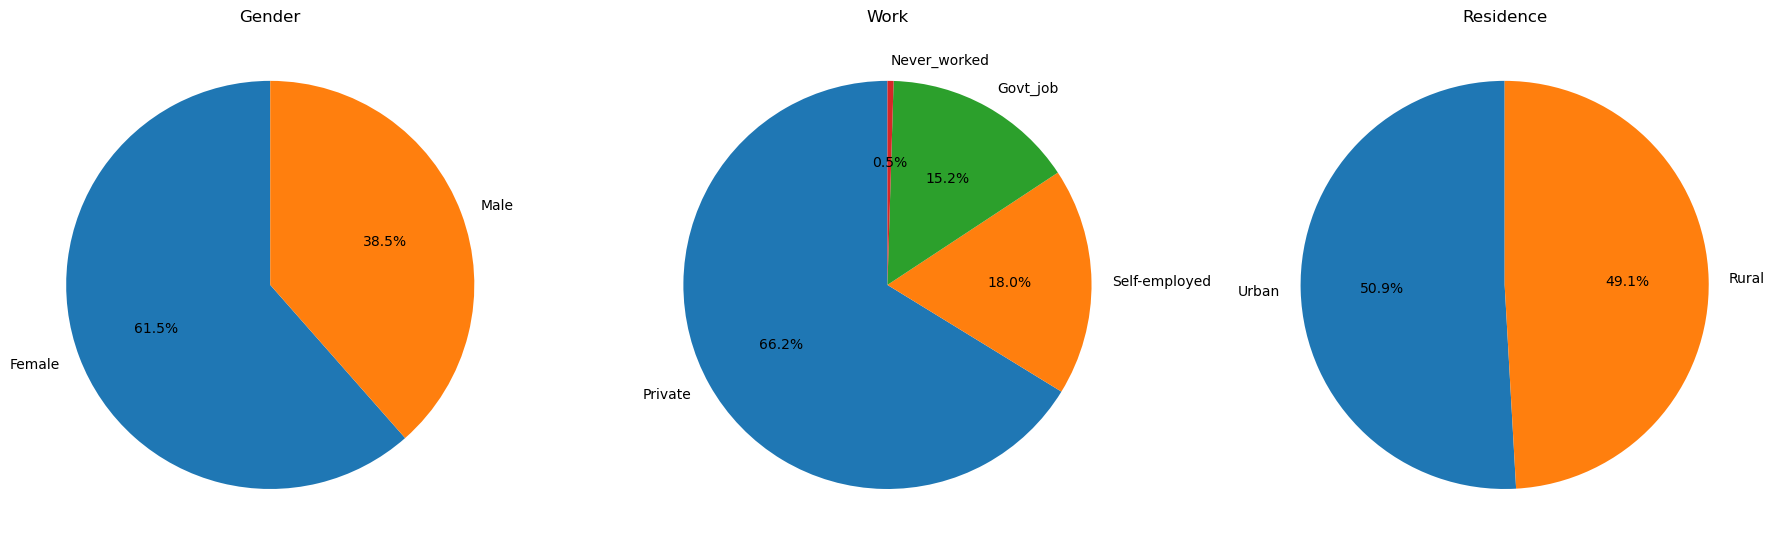

In [8]:
plt.figure(figsize=(18, 6))

# Pie plot of gender column
gender_counts = df['gender'].value_counts()
plt.subplot(1, 3, 1)
gender_counts.plot(kind='pie', autopct='%1.1f%%', startangle=90)
plt.title('Gender')
plt.ylabel('')

# Pie plot of work_type column
work_type_counts = df['work_type'].value_counts()
plt.subplot(1, 3, 2)
work_type_counts.plot(kind='pie', autopct='%1.1f%%', startangle=90)
plt.title('Work')
plt.ylabel('')

# Pie plot of Residence_type column
residence_type_counts = df['Residence_type'].value_counts()
plt.subplot(1, 3, 3) 
residence_type_counts.plot(kind='pie', autopct='%1.1f%%', startangle=90)
plt.title('Residence')
plt.ylabel('')

plt.tight_layout()
plt.show()

### 3.2 - Distributions

We analyze the distributions of key numerical variables, such as age, average glucose level, and BMI, by creating histograms. These visualizations help to identify the central tendency, spread, and any potential outliers in the data. Additionally, key statistics like mean, median, and standard deviation are annotated on the plots for a better understanding of the data distribution.

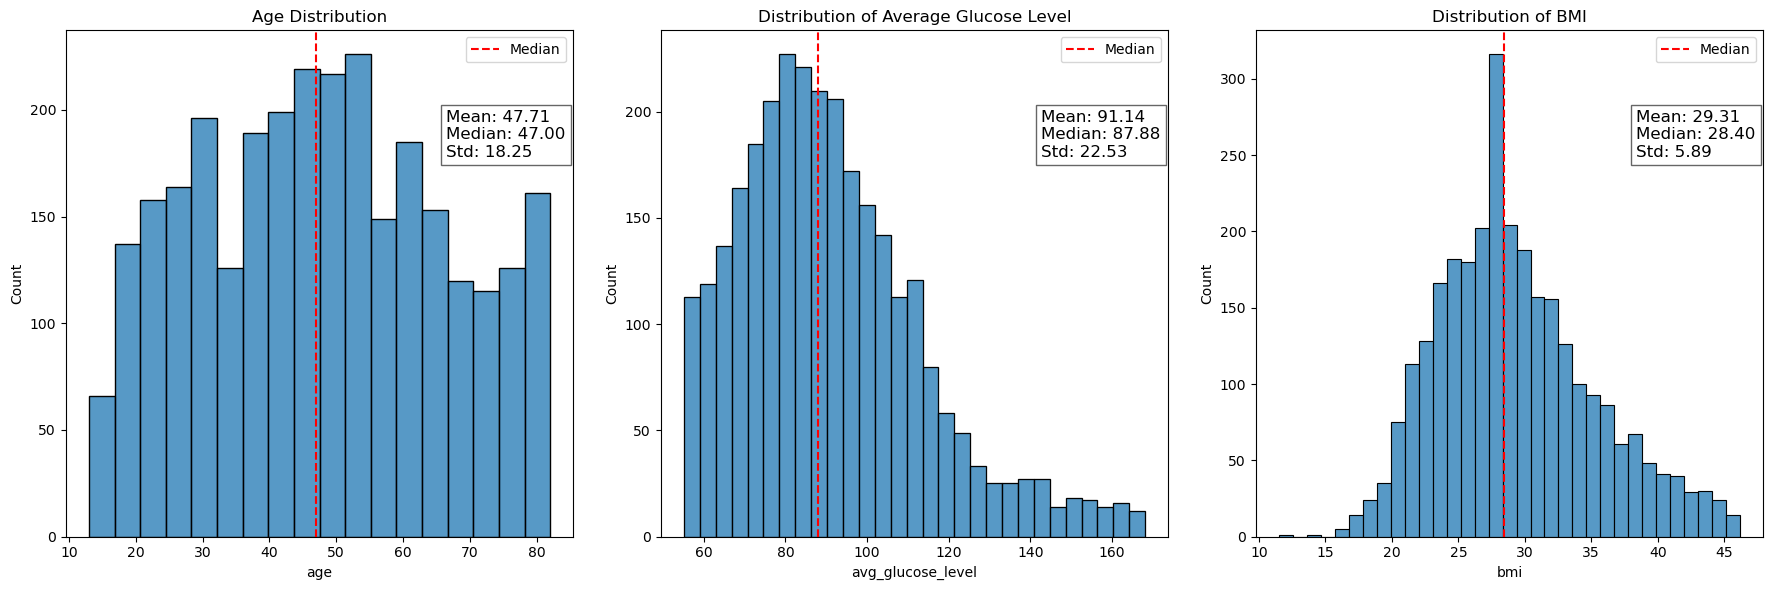

In [9]:
plt.figure(figsize=(18, 6))

age_stats = df['age'].describe()
glucose_stats = df['avg_glucose_level'].describe()
bmi_stats = df['bmi'].describe()


# Age distribution
plt.subplot(1, 3, 1)
sns.histplot(df['age'])
median_age = age_stats['50%']
plt.axvline(median_age, color='red', linestyle='--')
plt.title('Age Distribution')
plt.legend({'Median': median_age})
# Annotate statistics
stats_text = f"Mean: {age_stats['mean']:.2f}\nMedian: {median_age:.2f}\nStd: {age_stats['std']:.2f}"
plt.annotate(stats_text, xy=(0.75, 0.75), xycoords='axes fraction', fontsize=12,
             bbox=dict(facecolor='white', alpha=0.6))

# Distribution of average glucose level
plt.subplot(1, 3, 2)
sns.histplot(df['avg_glucose_level'])
median_glucose = glucose_stats['50%']
plt.axvline(median_glucose, color='red', linestyle='--')
plt.title('Distribution of Average Glucose Level')
plt.legend({'Median': median_glucose})
# Annotate statistics
stats_text = f"Mean: {glucose_stats['mean']:.2f}\nMedian: {median_glucose:.2f}\nStd: {glucose_stats['std']:.2f}"
plt.annotate(stats_text, xy=(0.75, 0.75), xycoords='axes fraction', fontsize=12,
             bbox=dict(facecolor='white', alpha=0.6))

# Distribution of BMI
plt.subplot(1, 3, 3)
sns.histplot(df['bmi'])
median_bmi = bmi_stats['50%']
plt.axvline(median_bmi, color='red', linestyle='--')
plt.title('Distribution of BMI')
plt.legend({'Median': median_bmi})
# Annotate statistics
stats_text = f"Mean: {bmi_stats['mean']:.2f}\nMedian: {median_bmi:.2f}\nStd: {bmi_stats['std']:.2f}"
plt.annotate(stats_text, xy=(0.75, 0.75), xycoords='axes fraction', fontsize=12,
             bbox=dict(facecolor='white', alpha=0.6))

plt.tight_layout()
plt.show()

### 3.3 - Feature Correlation Matrix

We calculate the correlation matrix for numerical features in the dataset to identify potential relationships between variables. A heatmap is plotted to visualize these correlations, which helps in understanding how variables are related to each other.

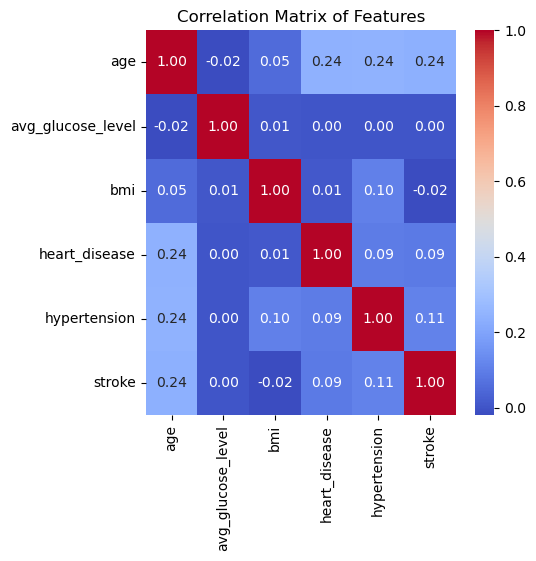

In [10]:
corr_matrix = df.corr(numeric_only=True)

# Plot a heatmap
plt.figure(figsize=(5, 5))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', annot_kws={"size": 10})
plt.title('Correlation Matrix of Features')
plt.show()

### 3.4 - Frequency Distribution

We analyze the frequency distribution of key health outcomes (hypertension, stroke, and heart disease) across different smoking statuses. Bar plots are used to show the percentages of these health outcomes for individuals who never smoked, formerly smoked, and currently smoke. This analysis helps in understanding the impact of smoking status on various health conditions.

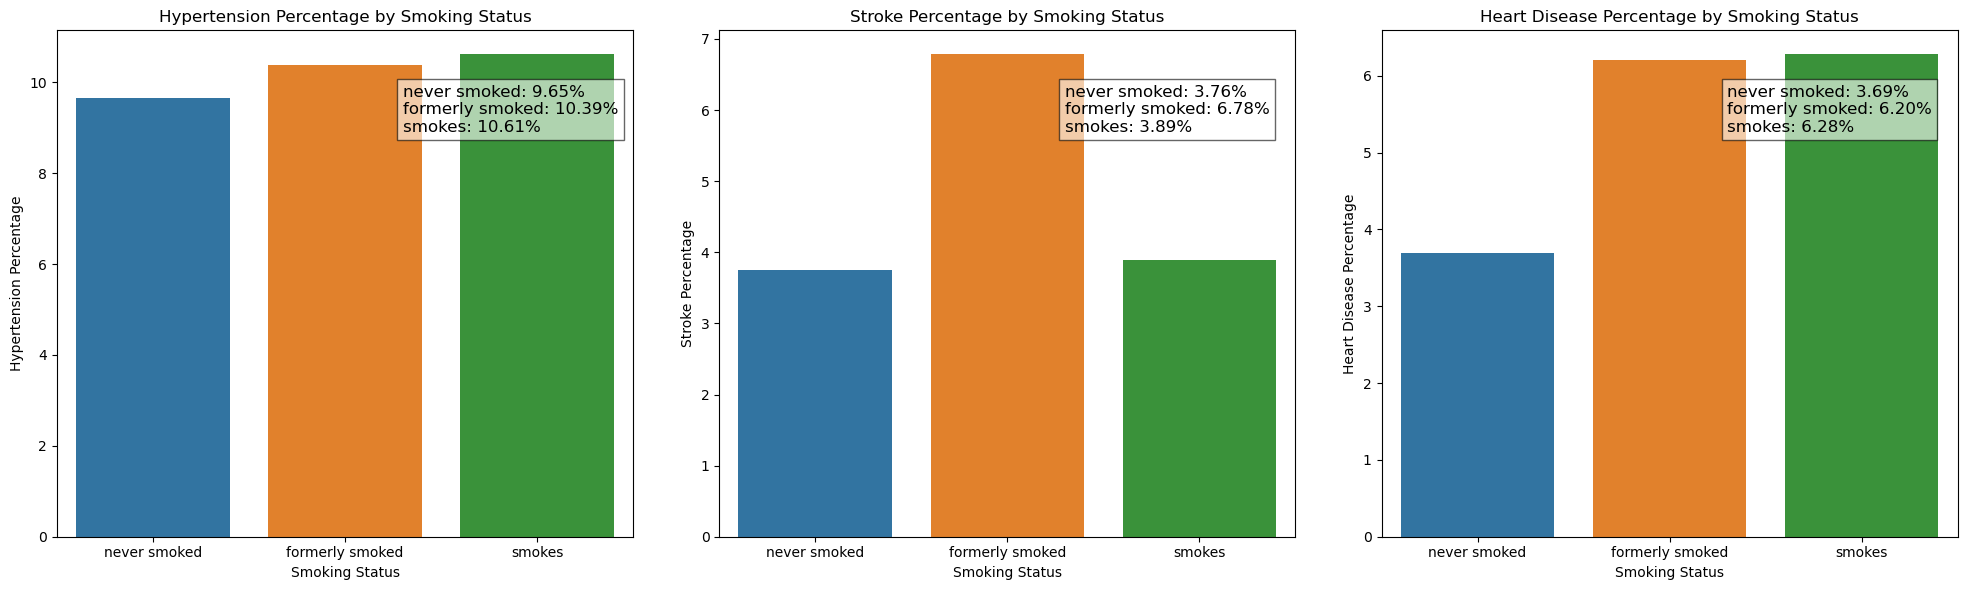

In [11]:
# reorder of variables
smoking_order = ['never smoked', 'formerly smoked', 'smokes']
df['smoking_status'] = pd.Categorical(df['smoking_status'], categories=smoking_order, ordered=True)

# Percentages
hypertension_percentage = df.groupby('smoking_status')['hypertension'].mean() * 100
stroke_percentage = df.groupby('smoking_status')['stroke'].mean() * 100
heart_disease_percentage = df.groupby('smoking_status')['heart_disease'].mean() * 100

# Plotting
plt.figure(figsize=(20, 6))

# Plot 1 - Hypertension Percentage
plt.subplot(1, 3, 1)
sns.barplot(x=hypertension_percentage.index, y=hypertension_percentage.values, order=smoking_order)
stats_text_hypertension = f"never smoked: {hypertension_percentage['never smoked']:.2f}%\nformerly smoked: {hypertension_percentage['formerly smoked']:.2f}%\nsmokes: {hypertension_percentage['smokes']:.2f}%"
plt.annotate(stats_text_hypertension, xy=(0.6, 0.8), xycoords='axes fraction', fontsize=12,
             bbox=dict(facecolor='white', alpha=0.6))
plt.title('Hypertension Percentage by Smoking Status')
plt.xlabel('Smoking Status')
plt.ylabel('Hypertension Percentage')

# Plot 2 - Stroke Percentage
plt.subplot(1, 3, 2)
sns.barplot(x=stroke_percentage.index, y=stroke_percentage.values, order=smoking_order)
stats_text_stroke = f"never smoked: {stroke_percentage['never smoked']:.2f}%\nformerly smoked: {stroke_percentage['formerly smoked']:.2f}%\nsmokes: {stroke_percentage['smokes']:.2f}%"
plt.annotate(stats_text_stroke, xy=(0.6, 0.8), xycoords='axes fraction', fontsize=12,
             bbox=dict(facecolor='white', alpha=0.6))
plt.title('Stroke Percentage by Smoking Status')
plt.xlabel('Smoking Status')
plt.ylabel('Stroke Percentage')

# Plot 3 - Heart Disease Percentage (placeholder example)
plt.subplot(1, 3, 3)
sns.barplot(x=heart_disease_percentage.index, y=heart_disease_percentage.values, order=smoking_order)
stats_text_heart_disease = f"never smoked: {heart_disease_percentage['never smoked']:.2f}%\nformerly smoked: {heart_disease_percentage['formerly smoked']:.2f}%\nsmokes: {heart_disease_percentage['smokes']:.2f}%"
plt.annotate(stats_text_heart_disease, xy=(0.6, 0.8), xycoords='axes fraction', fontsize=12,
             bbox=dict(facecolor='white', alpha=0.6))
plt.title('Heart Disease Percentage by Smoking Status')
plt.xlabel('Smoking Status')
plt.ylabel('Heart Disease Percentage')

plt.tight_layout()
plt.show()

## 4 - ANOVA Analysis

In this section, ANOVA (Analysis of Variance) is structured to provide insights into how smoking status potentially affects specific health metrics among individuals in the dataset. It enables comparison and statistical testing of these metrics across different groups, aiding in understanding any significant associations between smoking status and health outcomes like stroke, hypertension, and heart disease.

In [12]:
# Groups individuals by smoking status and extracts relevant data for analysis
smoking_status = df.groupby('smoking_status').groups

no_smokes_indices = smoking_status['never smoked']
formerly_smokers_indices = smoking_status['formerly smoked']
smokes_indices = smoking_status['smokes']

no_smokers = df.loc[no_smokes_indices]
formerly_smokers = df.loc[formerly_smokers_indices]
smokers = df.loc[smokes_indices]

def extract_data(df_no_smokers, df_formerly_smokers, df_smokers):
    """
    Extracts specific health metrics data (stroke, hypertension, heart disease) from different groups of individuals.

    Parameters:
    - df_no_smokers (DataFrame): DataFrame containing health metrics for individuals who are non-smokers.
    - df_formerly_smokers (DataFrame): DataFrame containing health metrics for individuals who formerly smoked.
    - df_smokers (DataFrame): DataFrame containing health metrics for individuals who currently smoke.

    Returns:
    - dict: A nested dictionary containing health metrics data categorized by smoking status.

    Explanation:
    This function extracts specific health metrics (stroke, hypertension, heart disease) from different groups of individuals
    categorized by smoking status. It creates a nested dictionary `data` where each key ('no_smokers', 'formerly_smokers', 'smokers')
    corresponds to a group of individuals, and each nested key ('stroke', 'hypertension', 'heart_disease') corresponds to a specific
    health metric. The values are Pandas Series containing the respective health metric data for each group.

    Example usage:
    ```
    data = extract_data(no_smokers_df, formerly_smokers_df, smokers_df)
    ```
    """

    no_smokers_stroke = df_no_smokers['stroke']
    no_smokers_hypertension = df_no_smokers['hypertension']
    no_smokers_heart_disease = df_no_smokers['heart_disease']

    formerly_smokers_stroke = df_formerly_smokers['stroke']
    formerly_smokers_hypertension = df_formerly_smokers['hypertension']
    formerly_smokers_heart_disease = df_formerly_smokers['heart_disease']

    smokers_stroke = df_smokers['stroke']
    smokers_hypertension = df_smokers['hypertension']
    smokers_heart_disease = df_smokers['heart_disease']

    data = {
        'no_smokers': {
            'stroke': no_smokers_stroke,
            'hypertension': no_smokers_hypertension,
            'heart_disease': no_smokers_heart_disease
        },
        'formerly_smokers': {
            'stroke': formerly_smokers_stroke,
            'hypertension': formerly_smokers_hypertension,
            'heart_disease': formerly_smokers_heart_disease
        },
        'smokers': {
            'stroke': smokers_stroke,
            'hypertension': smokers_hypertension,
            'heart_disease': smokers_heart_disease
        }
    }

    return data


def run_anova(data, column, groups):
    """
    Perform ANOVA (Analysis of Variance) on a specific health metric across different groups.

    Parameters:
    - data (dict): A nested dictionary containing health metric data categorized by groups.
    - column (str): The specific health metric ('stroke', 'hypertension', 'heart_disease') to test.
    - groups (list): List of group names to compare ('group1', 'group2', ...).

    Returns:
    - pandas.DataFrame: DataFrame containing ANOVA results for the specified health metric.

    Explanation:
    This function performs ANOVA to test the null hypothesis that the means of the specified health metric
    are equal across different groups. It extracts the data for the specified metric from each group in the
    input `data`, computes the ANOVA statistics (F-value and p-value), and returns these statistics in a
    structured DataFrame for easy interpretation and comparison.

    Example usage:
    ```
    data = extract_data(no_smokers, formerly_smokers, smokers)
    results_stroke = run_anova(data, 'stroke', groups)
    results_hypertension = run_anova(data, 'hypertension', groups)
    results_heart_disease = run_anova(data, 'heart_disease', groups)
    ```
    """
    
    all_values = []
    
    for group in groups:
        values = data[group][column]
        all_values.append(values)
    
    f_value, p_value = stats.f_oneway(*all_values)
    
    results_df = pd.DataFrame({
        'Tested Condition': column,
        'F-value': [f_value],
        'p-value': [p_value]
    })
 
    return results_df

def aggregate_anova_results(data, columns, groups):
    """
    Perform ANOVA (Analysis of Variance) on multiple variables across different groups and aggregate results.

    Parameters:
    - data (dict): A nested dictionary containing health metric data categorized by groups.
    - variables (list): List of health metrics (columns) to perform ANOVA on.
    - groups (list): List of group names to compare ('group1', 'group2', ...).

    Returns:
    - pandas.DataFrame: DataFrame containing aggregated ANOVA results for all variables.

    Explanation:
    This function iterates over each health metric specified in `variables`, performs ANOVA to test the null hypothesis
    that the means of the metric are equal across different groups, and aggregates the results into a single DataFrame.
    Each row in the DataFrame corresponds to the ANOVA results for one health metric across all groups.

    Example usage:
    ```
    variables = ['stroke', 'hypertension', 'heart_disease']
    groups = ['no_smokers', 'formerly_smokers', 'smokers']    
    data = extract_data(no_smokers, formerly_smokers, smokers)
    aggregated_results = aggregate_anova_results(data, variables, groups)
    ```
    """

    aggregated_results = pd.DataFrame()
    
    for column in columns:
        result_df = run_anova(data, column, groups)
        
        aggregated_results = pd.concat([aggregated_results, result_df], ignore_index=True)
    
    return aggregated_results


groups = ['no_smokers', 'formerly_smokers', 'smokers']
columns_of_interest = ['stroke', 'hypertension', 'heart_disease']

data = extract_data(no_smokers, formerly_smokers, smokers)

aggregate_anova_results(data, columns_of_interest, groups)

,Tested Condition,F-value,p-value
0,stroke,5.490935,0.004167
1,hypertension,0.297690,0.742554
2,heart_disease,5.073134,0.006318


## 5 - LSD Confidence Intervals

LSD stands for Least Significant Difference, which is a post-hoc analysis technique. It is used after conducting an ANOVA to compare the means of multiple groups to identify which specific pairs of group means are significantly different from each other. The LSD method calculates a confidence interval for the difference between each pair of group means. For hypertension, the F-value (0.297690) is not significant (p-value = 0.742554), indicating that there are no significant differences between groups for this condition. Therefore, LSD calculations would not be appropriate for hypertension based on these results.

In [13]:
def lsd(sig_level, MSE, n1, n2):
    t = stats.t.ppf(1-sig_level/2, n1+n2-2)
    return t*np.sqrt(MSE*(1/n1+1/n2))

# n e k
n = len(no_smokers) + len(formerly_smokers) + len(smokers)
k = 3  # Number of groups

# stroke
no_smokers_stroke_mean = no_smokers['stroke'].mean()
formerly_smokers_stroke_mean = formerly_smokers['stroke'].mean()
smokers_stroke_mean = smokers['stroke'].mean()

# rand mean
grand_mean_stroke = (no_smokers_stroke_mean + formerly_smokers_stroke_mean + smokers_stroke_mean) / k

# Calculation of the Sum of Squared Errors (SSE)
SSE_stroke = ((len(no_smokers['stroke']) - 1) * no_smokers['stroke'].var(ddof=1) +
              (len(formerly_smokers['stroke']) - 1) * formerly_smokers['stroke'].var(ddof=1) +
              (len(smokers['stroke']) - 1) * smokers['stroke'].var(ddof=1))

# Calculation of MSE
MSE_stroke = SSE_stroke / (n - k)

# sm = smokers, ns = no_smokers, fs = formerly_smokers
sm_ns_stroke = smokers_stroke_mean - no_smokers_stroke_mean
sm_fs_stroke = smokers_stroke_mean - formerly_smokers_stroke_mean
ns_fs_stroke = no_smokers_stroke_mean - formerly_smokers_stroke_mean

sm_ns_stroke_lsd_low = sm_ns_stroke - lsd(.05, MSE_stroke, len(smokers), len(no_smokers))
sm_ns_stroke_lsd_high = sm_ns_stroke + lsd(.05, MSE_stroke, len(smokers), len(no_smokers))

sm_fs_stroke_lsd_low = sm_fs_stroke - lsd(.05, MSE_stroke, len(smokers), len(formerly_smokers))
sm_fs_stroke_lsd_high = sm_fs_stroke + lsd(.05, MSE_stroke, len(smokers), len(formerly_smokers))

ns_fs_stroke_lsd_low = ns_fs_stroke - lsd(.05, MSE_stroke, len(no_smokers), len(formerly_smokers))
ns_fs_stroke_lsd_high = ns_fs_stroke + lsd(.05, MSE_stroke, len(no_smokers), len(formerly_smokers))

In [14]:
# heart_disease
no_smokers_heart_disease_mean = no_smokers['heart_disease'].mean()
formerly_smokers_heart_disease_mean = formerly_smokers['heart_disease'].mean()
smokers_heart_disease_mean = smokers['heart_disease'].mean()

# grand mean
grand_mean_heart_disease = (no_smokers_heart_disease_mean + formerly_smokers_heart_disease_mean + smokers_heart_disease_mean) / k

# Calculation of the Sum of Squared Errors (SSE)
SSE_heart_disease = ((len(no_smokers['heart_disease']) - 1) * no_smokers['heart_disease'].var(ddof=1) +
                     (len(formerly_smokers['heart_disease']) - 1) * formerly_smokers['heart_disease'].var(ddof=1) +
                     (len(smokers['heart_disease']) - 1) * smokers['heart_disease'].var(ddof=1))

# Calculation of MSE
MSE_heart_disease = SSE_heart_disease / (n - k)

# sm = smokers, ns = no_smokers, fs = formerly_smokers
sm_ns_hd = smokers_heart_disease_mean - no_smokers_heart_disease_mean
sm_fs_hd = smokers_heart_disease_mean - formerly_smokers_heart_disease_mean
ns_fs_hd = no_smokers_heart_disease_mean - formerly_smokers_heart_disease_mean

sm_ns_hd_lsd_low = sm_ns_hd - lsd(.05, MSE_heart_disease, len(smokers), len(no_smokers))
sm_ns_hd_lsd_high = sm_ns_hd + lsd(.05, MSE_heart_disease, len(smokers), len(no_smokers))

sm_fs_hd_lsd_low = sm_fs_hd - lsd(.05, MSE_heart_disease, len(smokers), len(formerly_smokers))
sm_fs_hd_lsd_high = sm_fs_hd + lsd(.05, MSE_heart_disease, len(smokers), len(formerly_smokers))

ns_fs_hd_lsd_low = ns_fs_hd - lsd(.05, MSE_heart_disease, len(no_smokers), len(formerly_smokers))
ns_fs_hd_lsd_high = ns_fs_hd + lsd(.05, MSE_heart_disease, len(no_smokers), len(formerly_smokers))


In [18]:
comparison_data = {
    'Comparison': [
        'Smokers - No Smokers (stroke)', 
        'Smokers - Formerly Smokers (stroke)', 
        'No Smokers - Formerly Smokers (stroke)',
        'Smokers - No Smokers (heart disease)', 
        'Smokers - Formerly Smokers (heart disease)', 
        'No Smokers - Formerly Smokers (heart disease)'
    ],
    'Point Estimate': [
        sm_ns_stroke, 
        sm_fs_stroke, 
        ns_fs_stroke, 
        sm_ns_hd, 
        sm_fs_hd, 
        ns_fs_hd
    ],
    'Lower Bound': [
        sm_ns_stroke_lsd_low, 
        sm_fs_stroke_lsd_low, 
        ns_fs_stroke_lsd_low, 
        sm_ns_hd_lsd_low, 
        sm_fs_hd_lsd_low, 
        ns_fs_hd_lsd_low
    ],
    'Upper Bound': [
        sm_ns_stroke_lsd_high, 
        sm_fs_stroke_lsd_high, 
        ns_fs_stroke_lsd_high, 
        sm_ns_hd_lsd_high, 
        sm_fs_hd_lsd_high, 
        ns_fs_hd_lsd_high
    ]
}

comparison_df = pd.DataFrame(comparison_data)

comparison_df

,Comparison,Point Estimate,Lower Bound,Upper Bound
0,Smokers - No Smokers (stroke),0.001299,-0.017508,0.020106
1,Smokers - Formerly Smokers (stroke),-0.028957,-0.050987,-0.006927
2,No Smokers - Formerly Smokers (stroke),-0.030256,-0.048834,-0.011678
3,Smokers - No Smokers (heart disease),0.025863,0.006319,0.045408
4,Smokers - Formerly Smokers (heart disease),0.000731,-0.022163,0.023626
5,No Smokers - Formerly Smokers (heart disease),-0.025132,-0.044439,-0.005825


* Significant differences are found between "Smokers vs. Formerly Smokers (stroke)," "No Smokers vs. Formerly Smokers (stroke)," "Smokers vs. No Smokers (heart disease)," and "No Smokers vs. Formerly Smokers (heart disease)" since the intervals don't include 0.
* No significant differences are found between "Smokers vs. No Smokers (stroke)" and "Smokers vs. Formerly Smokers (heart disease)" since the intervals include 0.

## 6 - Further investigations on hypertension

Following unexpected results from the ANOVA analysis, further investigation was conducted using regression analysis to explore the relationship between smoking status and hypertension. The regression model was employed to assess how different categories of smoking status influence the likelihood of hypertension

In [16]:
# dummies values for smoking status

df_dummies = pd.get_dummies(df, columns=['smoking_status'],  drop_first=True)

X = df_dummies[[col for col in df_dummies.columns if 'smoking_status_' in col]]
y = df_dummies['hypertension']  # Variabile dipendente

# regression model
model = sm.OLS(y, X)
results = model.fit()

results.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
smoking_status_formerly smoked,0.1039,0.012,8.856,0.000,0.081,0.127
smoking_status_smokes,0.1061,0.012,8.888,0.000,0.083,0.130


These results indicate that both formerly smoker and smokers have statistically significant positive effects on the outcome variable compared to the reference category. Individuals who have smoked in the past or currently smoke are associated with higher levels of the outcome variable, which could be a health condition such as hypertension.